<a href="https://colab.research.google.com/github/hugegene/LSTM-Prediction-of-Stock-Price-Movement/blob/master/SentimentTesting%20on%20USD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quant Machine Learning Research on USD (LSTM to Make Trading Decisions) RevB

## 1 Objective and Overview

A supervised learning was done to make trading decisions (Sell or Buy) for USD using USD's past price and MarketRisk TRMI.

The supervised model used was LSTM.  



## 1.1 Splitting Train-Validate-Test Set

1. Train from 2017-06-01 till 2018-05-31 (Blue)
2. Validate from 2018-06-01 till 2018-07-31 (Red)
3. Test from 2018-01-01 till 2018-12-08 (Green)



/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


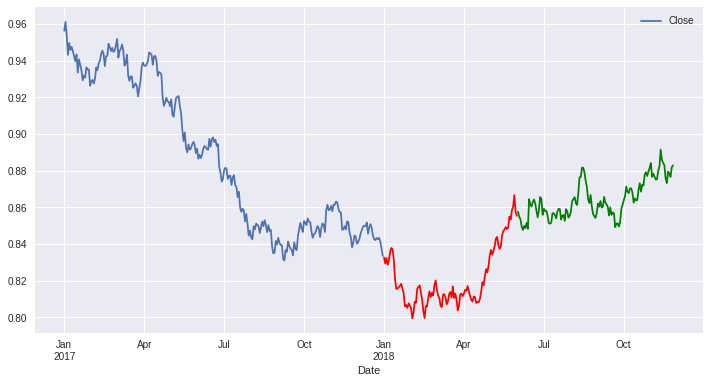

In [220]:
ax = tradeTable[:TRAIN_END].plot(y=['Close'], figsize=(12,6), grid=True)
tradeTable.Close[VALIDATE_START:VALIDATE_END].plot(ax=ax, color='r')
tradeTable.Close[TEST_START:].plot(ax=ax, color='g')

## 1.2 Feature Engineering

![alt text](https://github.com/hugegene/LSTM-Prediction-of-Stock-Price-Movement/blob/master/USDprice.png?raw=1)

USD price was overlayed with various TRMIs moving averages and the 30-days MarketRisk moving average seems to co-related well with the price visually. As such, the following was feature-enginnered as the input to the LSTM model for all the experiments:

1. 90-day MarketRisk moving-average
2. 30-day MarketRisk moving-average
3. Close
4. 100-day Close moving-average

## 1.3 Evaluation Metrics

The evaluation metrics are:
1. Matthews correlation coefficient (MCC)
2. Accuracy
3. Profit and Loss


## 1.4 Labels

Each timestep is labelled Sell(0) or Buy(1) depending on whether the net return is postive or negative in the next 7 trading days.


## 1.5 LSTM Set-Up

The LSTM is set-up to predict the labels based on the sequential data of the past 5 time-steps.


## 1.6 Trading

Each LSTM prediction of Buy will result in a buying and holding of USD for 1 day  and each LSTM prediction of Sell will result in a short-sell and holding of USD for 1 day.

## 2 Results 

Confusion matrix, without normalization
[[137  19]
 [ 73  31]]
Confusion matrix, without normalization
[[15 32]
 [ 7 54]]
Confusion matrix, without normalization
[[54  1]
 [57  9]]


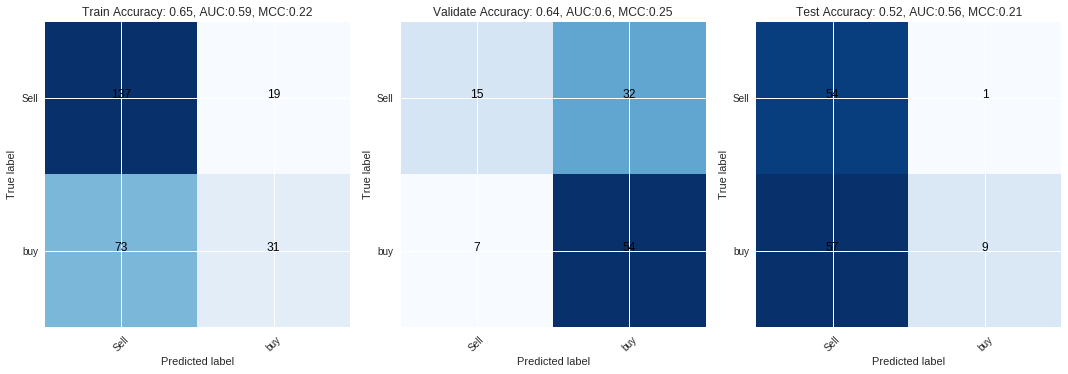

In [122]:
#plotting Confusion Matrix
f = plt.figure(figsize=(15,7))
ax = f.add_subplot(131)
plotConfusion(TRAIN_START, TRAIN_END, "Train")

plt.subplot(132)
plotConfusion(VALIDATE_START, VALIDATE_END, "Validate")

plt.subplot(133)
plotConfusion(TEST_START, TEST_END, "Test")

plt.show()

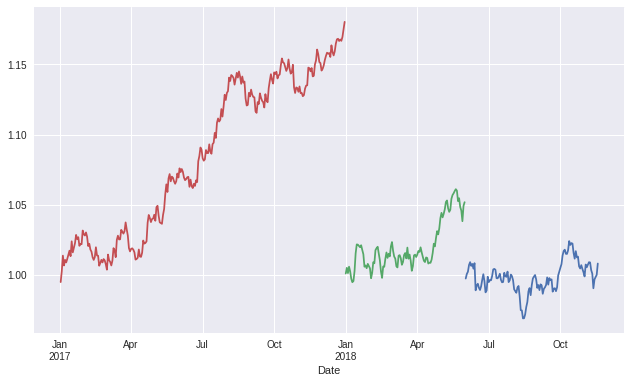

In [113]:
f = plt.figure(figsize=(36,6))
ax = f.add_subplot(131)

# PNL Plot for the Test Period
PNLTable["PNL"].plot()

# PNL Plot for the Test Period
ValTable["PNL"].plot()

# PNL Plot for the Test Period
TrainTable["PNL"].plot()

## 2.1 Evaluation
In the above PNL plot, the red shows the Training PNL, the green shows the Validate PNL, and the blue shows the Test PNL. The results show that the model is optimised for the Validate set as the Validate AUC and MCC  is the best. The test set however suffers from lower AUC and MCC and hence and a lousy PNL. There could be several reasons and difficulties:

1. The stocastic nature of the time series have training very random. Although there is consistency in achieving the approximately same maximum Accuracy, AUC, MCC by repeating the training under the same parameters, there is little consistency in reproducing th same PNL plots under the same parameters. This means that the model learns quite differently every time.

2. Because of the stocastic nature of the time series, the test set, validation set and training set may be very different in nature, as could be seen in the figure in 1.1), hence the results in the validation set may not be reproduced in the test set.

## 2.2 Proposal
I like to try a rolling train-test set up whereby the model will fit as far as it can go on the train set and use it to predict a short test period. In this way, the model is soley selected with the training data and validation period is not needed. The evaluation will be whether the methodology could produce consistent PNL over multiple rolling test periods.


##  3 Codes

In [2]:
from google.colab import files
uploaded = files.upload()

Saving USDprices.csv to USDprices.csv
Saving USDSentiment.csv to USDSentiment.csv


In [98]:
!ls

sample_data  USDprices.csv  USDSentiment.csv


In [0]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import model_from_json
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from datetime import datetime
import os
import itertools
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from keras.layers import Input, LSTM, RepeatVector, Lambda, Dense, Flatten, Permute, merge, multiply
from keras.models import Model
from keras import backend as K
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score as areauc
import tensorflow as tf

## 3.1 Data Preparation

In [100]:
##Read in Price data, use date as index
Prices = pd.read_csv("USDprices.csv")
Prices.head()
Prices['Date'].dtype
Prices['Date'] = pd.to_datetime(Prices['Date'], format='%Y-%m-%d')
Prices.head()
Prices.index = Prices['Date']
# print(Prices.head())

#Reading in Sentiment Data and selecting News-only-MarketRisk Sentiment
Sent = pd.read_csv("USDSentiment.csv")
Sent = Sent[Sent.dataType=='News'][['Date', 'marketRisk']].fillna(method = "ffill")
# Sent.head()
Sent['Date'] = pd.to_datetime(Sent['Date'], format='%Y-%m-%d')
Sent.index = Sent['Date']
# print(Sent.head())

#Combining Price table and Sentiment Table
Ana = Prices.merge(Sent, left_index= True, right_index=True, how='inner')
Ana.head()
Ana.columns
Ana = Ana.drop(columns=['Unnamed: 0', 'Volume', 'Asset', 'Date_x', 'Date_y', 'Open', 'High', 'Low', 'UnadjClose'])
Ana.head()

# calculating r, %tage change of closing price over previous time step
Ana['returns'] = (Ana['Close']- Ana['Close'].shift(1))/Ana['Close'].shift(1)
Ana.head()

# calculating target price
Ana['Target'] = Ana["Close"].diff(1).shift(-1)
Ana.head()

# calculating %change
Ana['Change'] = Ana["returns"].shift(-1)
Ana.head()


## Label each time step False(no-buy) or True(buy) based on whether the price will rise at the next closing price
timestep = 7
labels = []
for i in range(0, Ana.shape[0]):
  if(i+timestep< Ana.shape[0]):
    aheadGain = [Ana["returns"][i+j] for j in range(1,timestep+1)]
    labels+= [np.sum(aheadGain)> 0]

print(len(labels))

# Price Table with Labels as Signal
Ana = Ana.iloc[:-timestep,:].copy()
Ana.head()
Ana['Signal'] = labels
Ana.head()

#Feature Engineering
Ana["Close30"] =  Ana["Close"].rolling(30).mean()
Ana["Close100"] =  Ana["Close"].rolling(100).mean()
Ana["r1"] =  Ana["Close"].diff(1)
Ana["r2"] =  Ana["Close"].diff(7)
Ana["marketrisk_avg30"] = Ana["marketRisk"].rolling(30).mean()
Ana["marketrisk_avg90"] = Ana["marketRisk"].rolling(90).mean()

#Drop NA
Ana = Ana.dropna(0)
Ana.head()

5442


,Close,marketRisk,returns,Target,Change,Signal,Close30,Close100,r1,r2,marketrisk_avg30,marketrisk_avg90
Date,,,,,,,,,,,,
1998-05-21,0.894694,0.017921,-0.005816,-0.001439,-0.001608,True,0.905687,0.916241,-0.005234,-0.007833,0.030184,0.034995
1998-05-22,0.893256,0.054887,-0.001608,0.004813,0.005388,True,0.904816,0.916045,-0.001439,-0.011721,0.030500,0.035283
1998-05-25,0.898069,0.072076,0.005388,0.001373,0.001529,True,0.904089,0.915792,0.004813,-0.005518,0.031202,0.035543
1998-05-26,0.899442,0.120229,0.001529,0.006027,0.006700,False,0.903746,0.915530,0.001373,-0.007587,0.034618,0.036311
1998-05-27,0.905469,0.057863,0.006700,-0.001718,-0.001898,False,0.903617,0.915352,0.006027,-0.001643,0.036330,0.036533


In [101]:
#Define function to convert dataframe to training, validating and testing examples
def series_to_supervised(df, n_in=1, n_out=1):
	n_vars = 1 if type(df) is list else df.shape[1]
  
  
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, -1, -1):
		cols.append(df.shift(i))
		names += [(df.columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]

	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	return agg

#Features Selection
Set =  Ana[['Close', 'Close100', 'marketrisk_avg90', 'marketrisk_avg30']]
# Set =  Ana[['r1', 'r2']]
FEATURES_SHAPE =  Set.shape[1]
print(FEATURES_SHAPE)

#Forming examples
SEQ_LEN = 5
Set =  series_to_supervised(Set, SEQ_LEN-1, 0)
Set[["Change", "Signal"]] = Ana[["Change", "Signal"]]
Set = Set.dropna()
print(Set.shape)
Set.head()

4
(5339, 22)


,Close(t-4),Close100(t-4),marketrisk_avg90(t-4),marketrisk_avg30(t-4),Close(t-3),Close100(t-3),marketrisk_avg90(t-3),marketrisk_avg30(t-3),Close(t-2),Close100(t-2),...,Close(t-1),Close100(t-1),marketrisk_avg90(t-1),marketrisk_avg30(t-1),Close(t-0),Close100(t-0),marketrisk_avg90(t-0),marketrisk_avg30(t-0),Change,Signal
Date,,,,,,,,,,,,,,,,,,,,,
1998-05-27,0.894694,0.916241,0.034995,0.030184,0.893256,0.916045,0.035283,0.030500,0.898069,0.915792,...,0.899442,0.915530,0.036311,0.034618,0.905469,0.915352,0.036533,0.036330,-0.001898,False
1998-05-28,0.893256,0.916045,0.035283,0.030500,0.898069,0.915792,0.035543,0.031202,0.899442,0.915530,...,0.905469,0.915352,0.036533,0.036330,0.903751,0.915163,0.036895,0.035828,0.003719,False
1998-05-29,0.898069,0.915792,0.035543,0.031202,0.899442,0.915530,0.036311,0.034618,0.905469,0.915352,...,0.903751,0.915163,0.036895,0.035828,0.907112,0.915000,0.037338,0.036237,-0.004515,False
1998-06-01,0.899442,0.915530,0.036311,0.034618,0.905469,0.915352,0.036533,0.036330,0.903751,0.915163,...,0.907112,0.915000,0.037338,0.036237,0.903016,0.914801,0.037892,0.038099,0.000813,True
1998-06-02,0.905469,0.915352,0.036533,0.036330,0.903751,0.915163,0.036895,0.035828,0.907112,0.915000,...,0.903016,0.914801,0.037892,0.038099,0.903751,0.914626,0.038163,0.038561,-0.005840,True


In [102]:
#Remove bad training and validating examples
SetAdjusted = Set.copy()
# SetAdjusted = Set.loc[(Set.Change< -0.0015)| (Set.Change> 0.003)]
SetAdjusted.head()

,Close(t-4),Close100(t-4),marketrisk_avg90(t-4),marketrisk_avg30(t-4),Close(t-3),Close100(t-3),marketrisk_avg90(t-3),marketrisk_avg30(t-3),Close(t-2),Close100(t-2),...,Close(t-1),Close100(t-1),marketrisk_avg90(t-1),marketrisk_avg30(t-1),Close(t-0),Close100(t-0),marketrisk_avg90(t-0),marketrisk_avg30(t-0),Change,Signal
Date,,,,,,,,,,,,,,,,,,,,,
1998-05-27,0.894694,0.916241,0.034995,0.030184,0.893256,0.916045,0.035283,0.030500,0.898069,0.915792,...,0.899442,0.915530,0.036311,0.034618,0.905469,0.915352,0.036533,0.036330,-0.001898,False
1998-05-28,0.893256,0.916045,0.035283,0.030500,0.898069,0.915792,0.035543,0.031202,0.899442,0.915530,...,0.905469,0.915352,0.036533,0.036330,0.903751,0.915163,0.036895,0.035828,0.003719,False
1998-05-29,0.898069,0.915792,0.035543,0.031202,0.899442,0.915530,0.036311,0.034618,0.905469,0.915352,...,0.903751,0.915163,0.036895,0.035828,0.907112,0.915000,0.037338,0.036237,-0.004515,False
1998-06-01,0.899442,0.915530,0.036311,0.034618,0.905469,0.915352,0.036533,0.036330,0.903751,0.915163,...,0.907112,0.915000,0.037338,0.036237,0.903016,0.914801,0.037892,0.038099,0.000813,True
1998-06-02,0.905469,0.915352,0.036533,0.036330,0.903751,0.915163,0.036895,0.035828,0.907112,0.915000,...,0.903016,0.914801,0.037892,0.038099,0.903751,0.914626,0.038163,0.038561,-0.005840,True


## 3.2 Train-Validate-Test Split

In [103]:
#Set x and y variables
FIRSTTRAINVAR = SetAdjusted.columns[0]
print(FIRSTTRAINVAR)
LASTTRAINVARIABLE = SetAdjusted.columns[-3]
print(LASTTRAINVARIABLE)
YVAR= "Signal"

#Split train and test set at TRAIN_DATE_END and TEST_DATE_START
TRAIN_START = "2017-01-01"
TRAIN_END = "2017-12-31"
VALIDATE_START = "2018-01-01"
VALIDATE_END = "2018-05-31"
TEST_START = "2018-06-01"
TEST_END = "2018-12-08"

#Specify LSTM input shape
X_SHAPE1 = 5
X_SHAPE2 = FEATURES_SHAPE

#train_x
train_x = SetAdjusted.loc[TRAIN_START:TRAIN_END, FIRSTTRAINVAR:LASTTRAINVARIABLE]
# Normalised train_x to [0,1]
# print(train_x.head())
scaler = MinMaxScaler(feature_range=(0, 1))
train_x = scaler.fit_transform(train_x)
print(train_x.shape)
#reshape train_x for RNN input
train_x = train_x.reshape(train_x.shape[0], X_SHAPE1, X_SHAPE2)
print(train_x.shape)

#train_y
train_y = SetAdjusted.loc[TRAIN_START:TRAIN_END, YVAR]
train_y = train_y.values.reshape((train_y.shape[0], 1))
yscaler = MinMaxScaler(feature_range=(0, 1))
# train_y = yscaler.fit_transform(train_y)
print(train_y.shape)

#validate_x
validate_x = SetAdjusted.loc[VALIDATE_START:VALIDATE_END, FIRSTTRAINVAR:LASTTRAINVARIABLE]
# Normalised train_x to [0,1]
validate_x = scaler.transform(validate_x)
#reshape test_x for RNN input
validate_x = validate_x.reshape(validate_x.shape[0], X_SHAPE1, X_SHAPE2)
print(validate_x.shape)

#validate_y
validate_y = SetAdjusted.loc[VALIDATE_START:VALIDATE_END, YVAR]
validate_y = validate_y.values.reshape((validate_y.shape[0], 1))
# validate_y = yscaler.transform(validate_y)
print(validate_y.shape)

#test_x
test_x = Set.loc[TRAIN_START:TEST_END, FIRSTTRAINVAR:LASTTRAINVARIABLE]
# Normalised train_x to [0,1]
test_x = scaler.transform(test_x)
#reshape test_x for RNN input
test_x = test_x.reshape(test_x.shape[0], X_SHAPE1, X_SHAPE2)
print(test_x.shape)

#test_y
test_y = Set.loc[TRAIN_START:TEST_END, YVAR]
test_y = test_y.values.reshape((test_y.shape[0], 1))
# test_y = yscaler.transform(test_y)

print(test_y.shape)


TESTEND = test_x.shape[0]
TESTSTART = train_x.shape[0] + validate_x.shape[0]
VALIDATESTART = train_x.shape[0]

Close(t-4)
marketrisk_avg30(t-0)
(260, 20)
(260, 5, 4)
(260, 1)
(108, 5, 4)
(108, 1)
(489, 5, 4)
(489, 1)


## 3.3 Training

In [0]:
## Specifying Batch Size
n_batch = 2

In [105]:
## Only to use when removing model 
!rm best.h5

rm: cannot remove 'best.h5': No such file or directory


In [0]:
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

def areaUnderCurve(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc
  
#Check train_y statistic
trainStats = np.unique(train_y, return_counts=True)
print(trainStats)

#Set Classweight
if trainStats[1][0] > trainStats[1][1]: 
  classweight = {0:1, 1:trainStats[1][0]/trainStats[1][1]}
else:
  classweight = {0:trainStats[1][1]/trainStats[1][0], 1:1}
  
print(classweight)

units = 20
inputs = Input(shape=(train_x.shape[1], train_x.shape[2]))
secondary = LSTM(units, return_sequences=True)(inputs)
activations = LSTM(units, return_sequences=True)(secondary)
# out = Dense(1, activation='sigmoid')(activations)


attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2, 1])(attention)


sent_representation = multiply([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units,))(sent_representation)

probabilities = Dense(1, activation='sigmoid')(sent_representation)


model = Model(inputs=inputs, outputs=probabilities)
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=["binary_accuracy"])


# # Design LSTM Model
# model = Sequential()
# model.add(LSTM(20, input_shape=(train_x.shape[1], train_x.shape[2]),return_sequences=True, recurrent_dropout=0.0))
# model.add(LSTM(20, return_sequences=True, recurrent_dropout=0.0))

# # model.add(LSTM(20, batch_input_shape=(n_batch, train_x.shape[1], train_x.shape[2]),return_sequences=True, recurrent_dropout=0.0, stateful = True))
# # model.add(LSTM(20,return_sequences=False, recurrent_dropout=0.0, stateful = True))

# # model.add(Dense(20))
# # model.add(Activation('relu'))

# model.add(Dense(1))
# model.add(Activation('sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['matthews_correlation'])
# # model.compile(loss='mean_squared_error', optimizer='adam')

# Checkpoint
checkpoint = ModelCheckpoint("best.h5", monitor='val_binary_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=40, verbose=1, mode='auto')
callbacks_list = [checkpoint]

# Fit model
if os.path.isfile("best.h5"):
  model.load_weights("best.h5")

history = model.fit(train_x, train_y, epochs=150,  batch_size=n_batch, callbacks=[checkpoint, early],
                    validation_data=(validate_x, validate_y), shuffle=False, 
                      class_weight= classweight
                      )


# for i in range(30):
#   model.fit(train_x, train_y, epochs=1, batch_size=n_batch, shuffle=False, validation_data=(validate_x, validate_y), callbacks=[checkpoint, early] 
# #             ,class_weight= {0:1, 1:1}
#            )
#   model.reset_states()

<function matplotlib.pyplot.show>

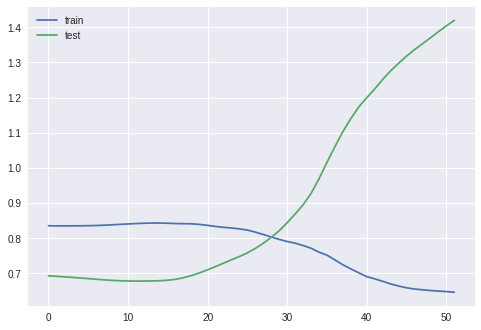

In [107]:
# Plot Learning Curve
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show

## 3.4  Predicting

In [108]:
# Make predictions, yhat, on test set
if os.path.isfile("best.h5"):
  model.load_weights("best.h5")
yhat = model.predict(test_x, batch_size=n_batch)
# yhat = yscaler.inverse_transform(yhat)

print(yhat.shape)

## Reading yhat as predictSignal
tradeTable= Ana.loc[TRAIN_START:,:].copy()
tradeTable["predictSignal"] = yhat>0.5
# tradeTable["predictPrice"] = yhat
# tradeTable["predictSignal"]= tradeTable["predictPrice"]>0
tradeTable.head()

#Changing Signals to Weights
tradeTable['predictedweight'] = np.where(tradeTable['predictSignal'] == True, 1, -1)
tradeTable['labelledweight'] = np.where(tradeTable['Signal'] == True, 1, -1)
tradeTable.head()

# calculating r, %tage change of closing price over previous time step
tradeTable['r'] = (tradeTable['Close']- tradeTable['Close'].shift(1))/tradeTable['Close'].shift(1)
tradeTable.head()

# calculating predicted and labelled trade returns over each time step
tradeTable['predictedreturns'] = tradeTable['r']*tradeTable['predictedweight'].shift(1)
tradeTable['labelledreturns'] = tradeTable['r']*tradeTable['labelledweight'].shift(1)

tradeTable.head()

# calculating cumulative predicted and labelled trade returns over each time step
TrainTable =  tradeTable.loc[TRAIN_START:TRAIN_END,:].copy()
TrainTable["labelledPNL"] =  (1+TrainTable['labelledreturns']).cumprod()
TrainTable["PNL"] = (1+TrainTable['predictedreturns']).cumprod()
TrainTable.head()

# calculating cumulative predicted and labelled trade returns over each time step
ValTable =  tradeTable.loc[VALIDATE_START:VALIDATE_END,:].copy()
ValTable["labelledPNL"] =  (1+ValTable['labelledreturns']).cumprod()
ValTable["PNL"] = (1+ValTable['predictedreturns']).cumprod()
ValTable.head()

# calculating cumulative predicted and labelled trade returns over each time step
PNLTable =  tradeTable.loc[TEST_START:"2018-12-08",:].copy()
PNLTable["labelledPNL"] =  (1+PNLTable['labelledreturns']).cumprod()
PNLTable["PNL"] = (1+PNLTable['predictedreturns']).cumprod()
PNLTable.head()

(489, 1)


,Close,marketRisk,returns,Target,Change,Signal,Close30,Close100,r1,r2,marketrisk_avg30,marketrisk_avg90,predictSignal,predictedweight,labelledweight,r,predictedreturns,labelledreturns,labelledPNL,PNL
Date,,,,,,,,,,,,,,,,,,,,
2018-06-01,0.857633,0.069993,0.002573,-0.002786,-0.003248,False,0.842374,0.820425,0.002201,0.002640,0.064267,0.047742,False,-1,-1,0.002573,-0.002573,-0.002573,0.997427,0.997427
2018-06-04,0.854847,0.041861,-0.003248,-0.001386,-0.001622,False,0.843562,0.820766,-0.002786,0.001532,0.062290,0.047795,False,-1,-1,-0.003248,0.003248,0.003248,1.000667,1.000667
2018-06-05,0.853461,0.046914,-0.001622,-0.004060,-0.004757,True,0.844756,0.821145,-0.001386,-0.004908,0.060955,0.047848,False,-1,1,-0.001622,0.001622,0.001622,1.002290,1.002290
2018-06-06,0.849401,0.038912,-0.004757,-0.001728,-0.002034,True,0.845654,0.821482,-0.004060,-0.011036,0.060158,0.048034,False,-1,1,-0.004757,0.004757,-0.004757,0.997522,1.007057
2018-06-07,0.847673,0.030235,-0.002034,0.002233,0.002635,True,0.846364,0.821787,-0.001728,-0.019028,0.059088,0.047821,False,-1,1,-0.002034,0.002034,-0.002034,0.995493,1.009106


In [0]:
# define confusion matrix function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

#     plt.figure(figsize= (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def plotConfusion(start, end, string):
  real = tradeTable["labelledweight"]
  pred = tradeTable["predictedweight"]
  cnf_matrix = confusion_matrix(real[start:end], pred[start:end])
  accuracy = np.around(accuracy_score(real[start:end], pred[start:end]),2)
  f1= np.around(f1_score(real[start:end], pred[start:end], average='binary'), 2)
  auc = np.around(areauc(real[start:end], pred[start:end]), 2)
  prec = np.around(precision_score(real[start:end], pred[start:end], average='binary'), 2)
  recall = np.around(recall_score(real[start:end], pred[start:end], average='binary'), 2)
  mcc =  np.around(matthews_corrcoef(real[start:end], pred[start:end]), 2)
  # np.set_printoptions(precision=2)


  plot_confusion_matrix(cnf_matrix, classes=['Sell', 'buy'],
                        title=string + ' Accuracy: ' +str(accuracy)
                        + ', AUC:' + str(auc)
#                         + ', F1 Score:' + str(f1)
#                         + ', Precison:' + str(prec)
#                         + ', Recall:' + str(recall)
                        + ', MCC:' + str(mcc))